<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/img_def_hu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Movement and deformation analysis from images

##Principles

*   Images/videos are made by a stable camera, to put it another way, the camera does not move during observations
*   Calibrated camera/system is necessary
*   Image resolution is enhanced by geodetic telescope


##Methods

*   Template matching
*   Pattern recognition

###Template matching characteristics

Pros

*   There is always a match
*   Simple algorithm
*   Special marker is not necessary

Cons

*   The chance of false match is higher
*   No or minimal rotation
*   No or minimal scale change

###Pattern recognition charasteristics

Pros

*   Marker can rotate
*   Marker scale can change
*   Normal of the marker can be estimated

Cons


*   Special marker have to be fit to target
*   More sensitive for light conditions


First off, let's import the necessary Python packages.

In [ ]:
 pip uninstall -q opencv-python

Found existing installation: opencv-python 4.7.0.72
Uninstalling opencv-python-4.7.0.72:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_python-4.7.0.72.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Core-39545cc7.so.5.15.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Gui-48e93776.so.5.15.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Test-c38a5234.so.5.15.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5XcbQpa-c112ba75.so.5.15.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libavcodec-16a334ab.so.59.37.100
    /usr/local/lib/py

In [ ]:
!apt install libopencv-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopencv-dev is already the newest version (4.2.0+dfsg-5+focal2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
!pip install opencv-python==4.5.4.60
!pip install opencv-contrib-python==4.5.4.60

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.7.0.72
    Uninstalling opencv-contrib-python-4.7.0.72:
      Successfully uninstalled opencv-contrib-python-4.7.0.72


In [ ]:
import glob                         # to extend file name pattern to list
import cv2                          # OpenCV for image processing
from cv2 import aruco               # to find ArUco markers
import numpy as np                  # for matrices
import matplotlib.pyplot as plt     # to show images
cv2.__version__

'4.5.4'

##Template matching

Let's first download an image and a template to search for. The template is a smaller part of the original image.

In [ ]:
!wget -q -O sample_data/monalisa.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/monalisa.jpg
!wget -q -O sample_data/mona_temp4.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/mona_temp4.png

Both the image used for processing and the template are converted to grayscale images to boost efficiency.

image sizes: (276, 182)  template sizes: (76, 52)


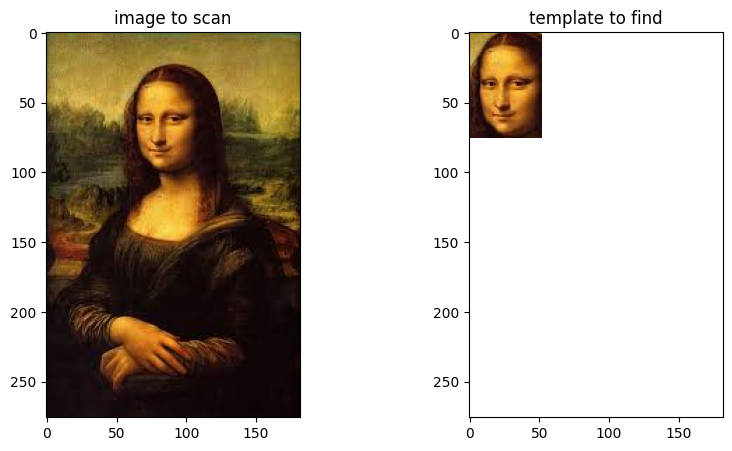

In [ ]:
img = cv2.imread('sample_data/monalisa.jpg')          # load image
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      # convert image to grayscale
templ = cv2.imread('sample_data/mona_temp4.png')      # load template
templ_gray = cv2.cvtColor(templ, cv2.COLOR_BGR2GRAY)  # convert template to grayscale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) # show image and template
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('image to scan')
ax2.imshow(cv2.cvtColor(templ, cv2.COLOR_BGR2RGB))    # BGR vs. RGB
ax2.set_title('template to find')
ax2.set_xlim(ax1.get_xlim())                          # set same scale
ax2.set_ylim(ax1.get_ylim())
print(f'image sizes: {img_gray.shape}  template sizes: {templ_gray.shape}')

*Change the code above to plot grayscale images.*

The OpenCV package has a function for template mathing, so let's call it and display the result. The *matchTemplate* function can calculate six different formulas to find the best match. Within the function, *TM_CCOEFF_NORMED* it calculates a normalized coefficient in the range (0, 1), where the perfect match gives value 1.

best match at (57, 25) value 1.000000


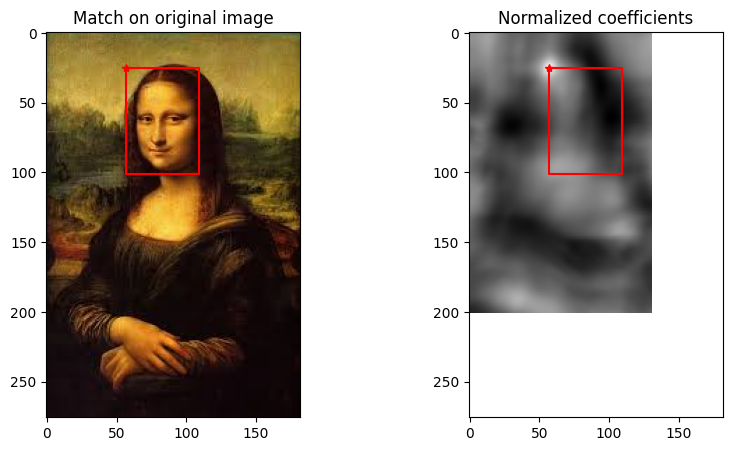

In [ ]:
result = cv2.matchTemplate(img_gray, templ_gray, cv2.TM_CCOEFF_NORMED)
val, _, max = cv2.minMaxLoc(result)[1:4]        # get position of best match
fr = np.array([max,
               (max[0]+templ.shape[1], max[1]),
               (max[0]+templ.shape[1], max[1]+templ.shape[0]),
               (max[0], max[1]+templ.shape[0]),
               max])
result_uint = ((result - np.min(result)) / (np.max(result) - np.min(result)) * 256).astype('uint8')
result_img = cv2.cvtColor(result_uint, cv2.COLOR_GRAY2BGR)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Match on original image')
ax1.plot(fr[:,0], fr[:,1], 'r')
ax1.plot([max[0]],[max[1]], 'r*')
ax2.imshow(result_img)
ax2.plot(fr[:,0], fr[:,1], 'r')
ax2.plot([max[0]],[max[1]], 'r*')
ax2.set_title('Normalized coefficients')
ax2.set_xlim(ax1.get_xlim())                          # set same scale
ax2.set_ylim(ax1.get_ylim())
print(f'best match at {max} value {val:.6f}')


*Change the code above and try other methods, TM_CCORR_NORMED, TM_SQDIFF_NORMED, for instance.*

###Image transformation

If the pattern is rotated or scaled, the pattern might not match the image. This issue can be fixed by using homology matrix. For more details see: [source](https://github.com/jephraim-manansala/object-detection/blob/master/Object%20Detection%20using%20Template%20Matching.ipynb)

Let's download another image with a rotated Mona Lisa.

In [ ]:
!wget -q -O sample_data/monalisa_tilt.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/monalisa_tilt.jpg

Let's try to find the template on the rotated image.

best match at (467, 240) value 0.574011 BUT FALSE!


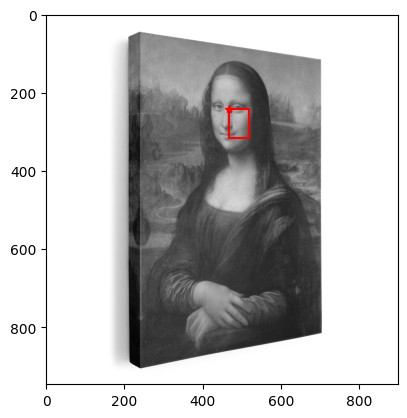

In [ ]:
img = cv2.imread('sample_data/monalisa_tilt.jpg', cv2.IMREAD_GRAYSCALE)
result = cv2.matchTemplate(img, templ_gray, cv2.TM_CCOEFF_NORMED)
val, _, max = cv2.minMaxLoc(result)[1:4]
fr = np.array([max,
               (max[0]+templ.shape[1], max[1]),
               (max[0]+templ.shape[1], max[1]+templ.shape[0]),
               (max[0], max[1]+templ.shape[0]),
               max])
plt.imshow(img, cmap="gray")
plt.plot(fr[:,0], fr[:,1], 'r')
plt.plot([max[0]],[max[1]], 'r*')
print(f'best match at {max} value {val:.6f} BUT FALSE!')

Let's transform the image back to the perpendicular plan.

In [ ]:
def project_img(image, a_src, a_dst):
    """ calculate transformation matrix """

    new_image = image.copy()                       # make a copy of input image
    # get parameters of transformation
    projective_matrix = cv2.getPerspectiveTransform(a_src, a_dst)
    # transform image
    transformed = cv2.warpPerspective(img, projective_matrix, image.shape)
    # cut destination area
    transformed = transformed[0:int(np.max(a_dst[:,1])),0:int(np.max(a_dst[:,0]))]
    return transformed

best match at (55, 19) value 0.92


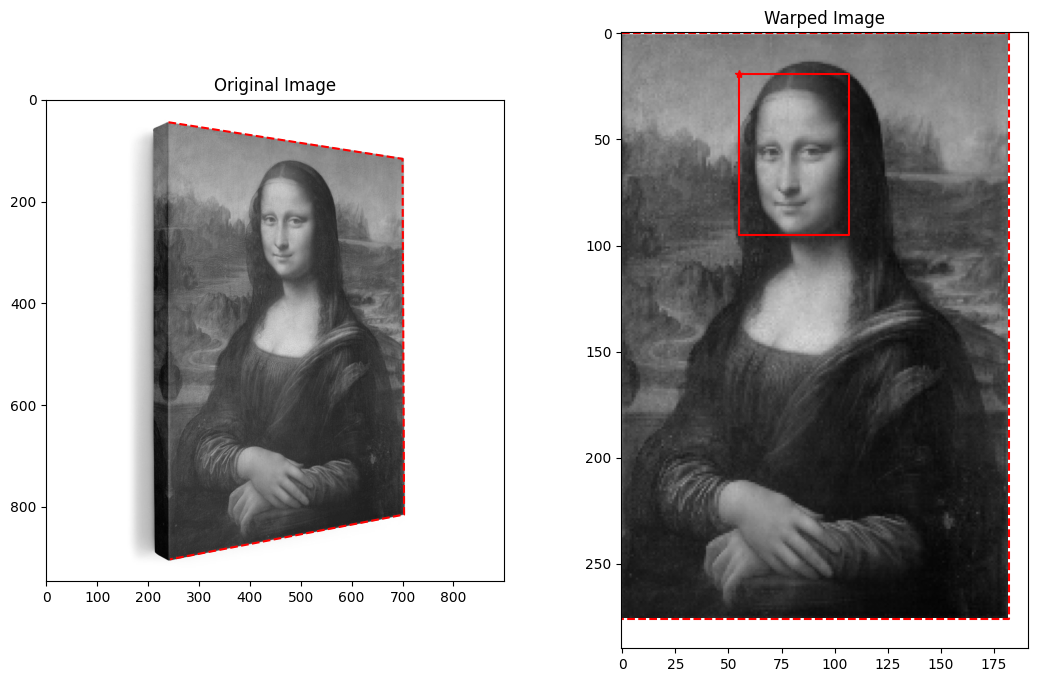

In [ ]:
# frame on warped image
src = [(240, 44), (700, 116), (703, 815), (243, 903)]
# frame on original
s = img_gray.shape
dst = [(0, 0), (s[1], 0), (s[1], s[0]), (0,s[0])]
a_src = np.float32(src)
a_dst = np.float32(dst)
# image transformation
img_dst = project_img(img, a_src, a_dst)
# template match
result = cv2.matchTemplate(img_dst, templ_gray, cv2.TM_CCOEFF_NORMED)
val, _, max = cv2.minMaxLoc(result)[1:4]
# frame around template on transformed image
fr = np.array([max,
               (max[0]+templ.shape[1], max[1]),
               (max[0]+templ.shape[1], max[1]+templ.shape[0]),
               (max[0], max[1]+templ.shape[0]),
               max])
fig, ax = plt.subplots(1,2, figsize=(13,8))
ax[0].imshow(img, cmap="gray");
ax[0].plot(a_src[:,0], a_src[:,1], 'r--')
ax[0].set_title('Original Image')
ax[1].imshow(img_dst, cmap="gray")
ax[1].plot(a_dst[:,0], a_dst[:,1], 'r--')
ax[1].set_title('Warped Image')
ax[1].plot(fr[:,0], fr[:,1], 'r')
ax[1].plot([max[0]],[max[1]], 'r*')
print(f'best match at {max} value {val:.2f}')

##Recognition of ArUco markers

"An ArUco marker is a synthetic square marker composed by a wide black border and an inner binary matrix which determines its identifier (id). The black border facilitates its fast detection in the image and the binary codification allows its identification and the application of error detection and correction techniques. The marker size determines the size of the internal matrix. For instance a marker size of 4x4 is composed by 16 bits." (*from OpenCV documentation*)

There is a contrib package in OpenCV to detect ArUco markers called *aruco*.

Let's find six ArUco markers on a simple image.

In [ ]:
!wget -q -O sample_data/markers.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/markers.png
img = cv2.imread('sample_data/markers.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

[(502.0, 342.0), (328.0, 342.0), (152.0, 342.0), (502.0, 142.0), (328.0, 142.0), (152.0, 142.0)]


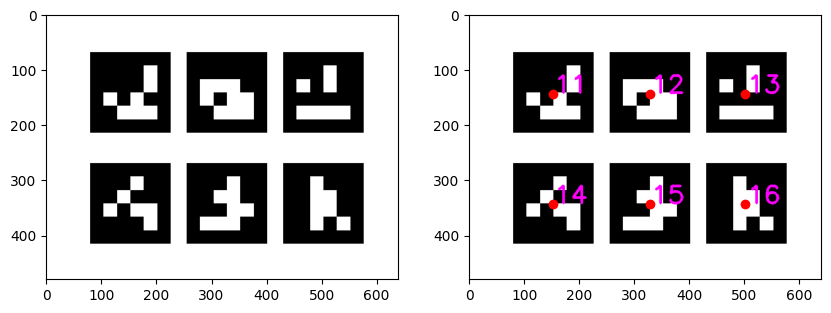

In [ ]:
aruco_dict = aruco.Dictionary_get(cv2.aruco.DICT_4X4_100)
params = aruco.DetectorParameters_create()
corners, ids, _ = aruco.detectMarkers(img_gray, aruco_dict, parameters=params)
x = np.zeros(ids.size)
y = np.zeros(ids.size)
img1 = img.copy()
for j in range(ids.size):
  x[j] = int(round(np.average(corners[j][0][:, 0])))
  y[j] = int(round(np.average(corners[j][0][:, 1])))
  cv2.putText(img1, str(ids[j][0]), (int(x[j]+2), int(y[j])), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 255), 3)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(img1)
ax[1].plot(x, y, "ro")
print(list(zip(list(x), list(y))))

##Calibration

Low-cost cameras might have significant distortions (either radial or tangential). Therefore, we have to calibrate cameras before using in deformation and movement analysis.

###Radial distortion

$$ x' = x (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) $$
$$ y' = y (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) $$

###Tangential distortion

$$ x' = x + (2 p_1 x y + p_2 (r^2 + 2 x^2)) $$
$$ y' = y + (p_1 (r^2+2 y^2) + 2 p_2 x y) $$

###Camera matrix

<table>
<tr><td>f<sub>x</sub></td><td>0</td><td>c<sub>x</sub></td></tr>
<tr><td>0</td><td>f<sub>y</sub></td><td>c<sub>y</sub></td></tr>
<tr><td>0</td><td>0</td><td>1</td></tr></table>


Distortion parameters are ($ k_1, k_2, k_3, p_1, p_2 $). Camera matrix contains focal length ($ f_x, f_y $) and optical centers ($ c_x, c_y $).

For the calibration we need a chessboard like figure and more than ten photos from different directions.

Let's download the images for calibration.

In [ ]:
!wget -q -O sample_data/cal.zip https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/cal.zip
!unzip -q -o sample_data/cal.zip -d sample_data

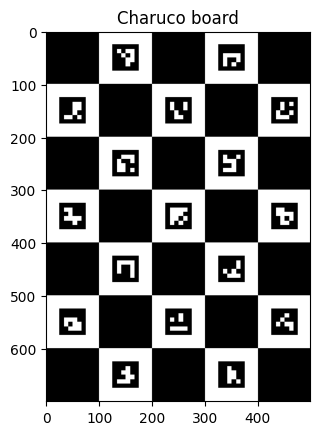

In [ ]:

width = 5       # Charuco board size
height = 7
board = cv2.aruco.CharucoBoard_create(width, height, .025, .0125, aruco_dict)   # generate board in memory
img = board.draw((500, 700))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
_ = plt.title('Charuco board')

The first 6 images for calibration:

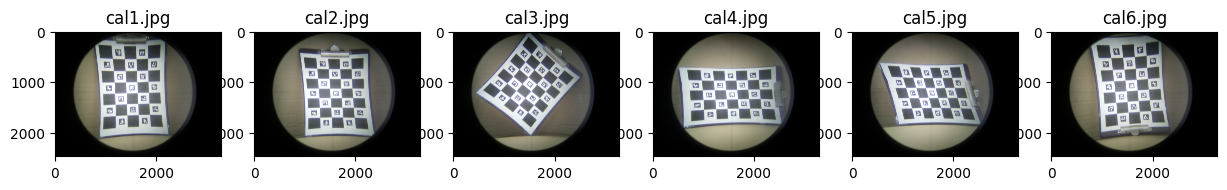

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6):
    im = cv2.imread('sample_data/cal{:d}.jpg'.format(i+1))
    ax[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax[i].set_title('cal{:d}.jpg'.format(i+1))

Using the ArUco calibration, let's find the camera matrix and the associated radial and tangential distortion parameters.

In [ ]:
allCorners = []
allIds = []
decimator = 0

for name in glob.glob("sample_data/cal*.jpg"):
  frame = cv2.imread(name)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  corners, ids, _ = cv2.aruco.detectMarkers(gray, aruco_dict)
  ret, corners1, ids1 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)
  allCorners.append(corners1)
  allIds.append(ids1)
  decimator += 1

ret, mtx, dist, rvecs, tvecs = cv2.aruco.calibrateCameraCharuco(allCorners, allIds, board, gray.shape, None, None)
print("Camera matrix [pixels]")
for i in range(mtx.shape[0]):
  print(f'{mtx[i][0]:8.1f} {mtx[i][1]:8.1f} {mtx[i][2]:8.1f}')
print('Radial components')
print(30 * '-')
print(f'{dist[0][0]:10.5f} {dist[0][1]:10.5f} {dist[0][2]:10.5f}')
print(30 * '-')
print('Tangential components')
print(f'{dist[0][3]:10.5f} {dist[0][4]:10.5f}')

Camera matrix [pixels]
 28006.7      0.0   1379.0
     0.0  26830.6   1485.7
     0.0      0.0      1.0
Radial components
------------------------------
  74.69394  -31.12575    0.67060
------------------------------
Tangential components
  -0.58165   -0.34230


Plot undistorted image and the one corrected by calibration parameters.

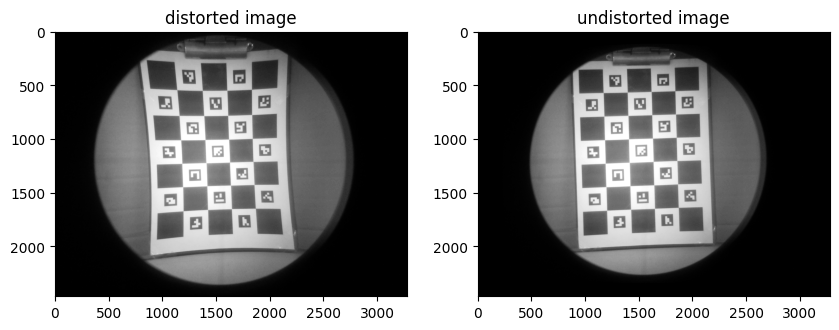

In [ ]:
gray = cv2.imread('sample_data/cal1.jpg', cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(gray, cmap='gray')
ax[0].set_title('distorted image')
ax[1].imshow(cv2.undistort(gray, mtx, dist, None), cmap='gray')
_ = ax[1].set_title('undistorted image')

##Complex example

We have a video of a moving object with an ArUco marker. Let's process the video frame by frame and make a plot of movements. During the process images are corrected by the calibration data.

[Click here](https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/demo.mp4) to watch video.


In [ ]:
!wget -q -O sample_data/demo.mp4 https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/demo.mp4

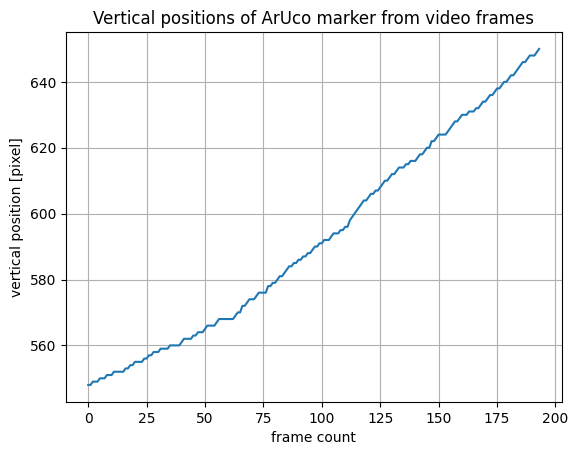

In [ ]:
cap = cv2.VideoCapture('sample_data/demo.mp4')
frame = 0                 # frame counter
xc = []                   # for pixel coordinates of marker
yc = []
frames = []
while True:
  ret, img = cap.read()   # get next frame from video
  if ret:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # convert image to grayscale
    img_gray = cv2.undistort(gray, mtx, dist, None)     # remove camera distortion using calibration
    corners, ids, _ = aruco.detectMarkers(img_gray, aruco_dict, parameters=params)  # find ArUco markers
    if ids:                                             # marker found?
      yc.append(img_gray.shape[1] - int(round(np.average(corners[0][0][:, 1]))))  # change y direction
      frames.append(frame)
    frame += 1                                          # frame count
  else:
    break       # no more images
plt.plot(frames, yc)
plt.title('Vertical positions of ArUco marker from video frames')
plt.xlabel('frame count')
plt.grid()
_ = plt.ylabel('vertical position [pixel]')

*Convert pixels to mm and frames to seconds (video has 2 fps, the size of the marker is 6.5 cm).*

##Tasks to do


* Calibrate the camera of your laptop. Use e.g. windows built-in camera application to take images
* Try *charuco.py* from Ulyxes to calibrate your camera and save the parameters
* Take an image of an AruCo code using your laptop camera. Find its position using either template matching or Aruco finding methods
* Take an image of more AruCo codes. Find their positions applying Aruco finding methods
* Try *video_aruco.py* and *video_correlation.py* from Ulyxes. Use your laptop camera and find Aruoco code position in real-time.
* Create a time, x or time, y graph from the output of *video_aruco.py* and *video_correlation.py*
* Calibrate the camera of your mobile
* Blur the images (monalisa.jpg, markers.png) and try to use both methods
* Modify the code of the complex example to use template matching method instead of AruCo code recognition